In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
# !curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
import matplotlib.pyplot as plt
# conda_installer.install()
# conda_installer.install()
# !/root/miniconda/bin/conda info -e
import rdkit

In [3]:
df = pd.read_csv('../Datasets/Mobley/info.csv')
df = df.dropna()
# df = df[df['Dataset Name'] == 'cd-set1']

In [4]:
training_cols = [col for col in df.columns if (col[:3] == 'gb_' and not col.__contains__('Etot') and not col.__contains__('Ex_') and not col.__contains__('delta')) or (col.__contains__('VDWAALS'))]
# training_cols = ['gb_Ex_difference']

In [ ]:
df[['EX _H_(kcal/mol)', 'gb_Ex_difference']]

In [ ]:
df

In [5]:
PDBs = {}
from os import listdir
from os.path import isfile, join
pdb_paths = [
    '../Datasets/Mobley/cd-set1/pdb/',
    '../Datasets/Mobley/cd-set2/pdb/',
    '../Datasets/Mobley/gdcc-set1/pdb/',
    '../Datasets/Mobley/BRD4/pdb/',
]
for mypath in pdb_paths:
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    host_name = [x for x in onlyfiles if x.__contains__('host') or x.__contains__('BRD')][0]
    host_mol = rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + host_name)
    onlyfiles.remove(host_name)
    for f in onlyfiles:
        if f.split('.')[0] in df['Guest'].to_numpy():
            guest_mol = rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + f)
            PDBs.update({host_name.split('.')[0] + '_' + f.split('.')[0] : rdkit.Chem.CombineMols(host_mol,guest_mol)})

In [ ]:
PDBs

In [6]:
def draw_mol(mol):
    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(800, 800)
    draw_options = drawer.drawOptions()
    draw_options.minFontSize = -1
    draw_options.maxFontSize = -1
    draw_options.scaleBondWidth = True
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

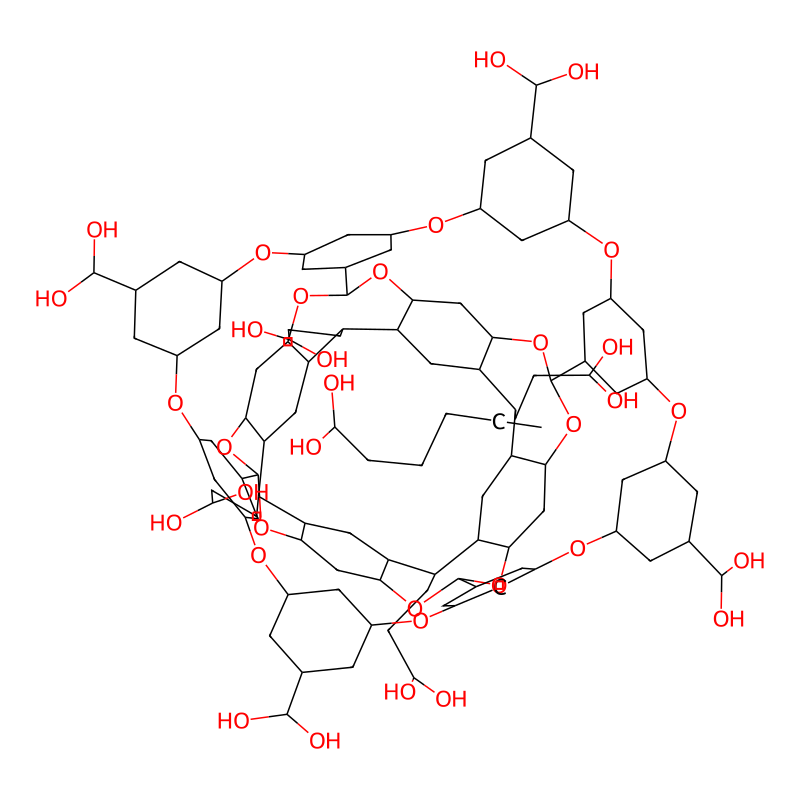

In [7]:
from IPython.display import SVG, display
%matplotlib inline
SVG(data=draw_mol(PDBs['host-oa_guest-3']))

# Check if adj matrix can be tensorized

In [8]:
%cd ..

C:\Users\arisheh\PycharmProjects\GBNN


In [9]:
%cd PGGCN

C:\Users\arisheh\PycharmProjects\GBNN\PGGCN


In [10]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Guest'] == pdb.split('_')[1].replace('-s', '-')][training_cols].to_numpy()[0])

In [11]:
from dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]
        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [12]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Guest'] == pdb.split('_')[1].replace('-s', '-')]['EX _H_(kcal/mol)'].abs().to_numpy()[0])

In [13]:
X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]
info_train, info_test = info[:int(.8*len(X))], info[int(.8*len(X)):]

In [ ]:
y_test

In [14]:
sample_x_atoms = X[:10]
for i in range(len(sample_x_atoms)):
    if sample_x_atoms[i].shape[0] < 2000:
        new_list = sample_x_atoms[i].tolist()
        for j in range(2000 - sample_x_atoms[i].shape[0]):
            new_list.append([0.0]*53)
#         new_list.append(np.concatenate((info[i], [0]*65)))
        sample_x_atoms[i] = np.array(new_list)
sample_x_atoms = np.array(sample_x_atoms)

In [ ]:
info[0]

In [ ]:
sample_x_atoms[0][0][38:]

In [ ]:
info[0]

In [15]:
physics_info = []
for i in range(len(X_train)):
    physics_info.append(X_train[i][0][38:])

In [ ]:
X_train[:,0,38:].shape

In [16]:
import layers_update_mobley as layers
import importlib
import tensorflow_addons as tfa
importlib.reload(layers)


class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')
#         self.dense2 = tf.keras.layers.Dense(32, activation='sigmoid')
#         self.dense3 = tf.keras.layers.Dense(100, activation='relu')
#         self.dense4 = tf.keras.layers.Dense(80, activation='relu')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([-.2,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
#         agg = []
#         for i in range(len(x_a)):
#             agg.append([x_a[i], self.a_l[i]])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
#         x = self.dense2(x)
#         x = self.dense3(x)
#         x = self.dense4(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out

m = PGGCNModel()
m.addRule("sum", 0, 31)
m.addRule("multiply", 31, 33)
m.addRule("distance", 33, 36)

import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=0.1),
    tf.keras.optimizers.Adam(learning_rate=0.005)
]
optimizers_and_layers = [(optimizers[0], m.layers[:len(m.layers) - 1]), 
                         (optimizers[1], m.layers[len(m.layers) - 1])]    
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
m.compile(loss=pure_rmse, optimizer=opt)

X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]
info_train, info_test = info[:int(.8*len(X))], info[int(.8*len(X)):]

input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 53])
#         for j in range(2000 - X_atoms[i].shape[0]):
#             new_list.append(np.zeros(53))
#         new_list.append(np.concatenate((info[i], [0]*65)))
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
X_train = np.array(X_train)
y = np.array(y_train)
hist = m.fit(X_train, y, epochs = 100)

C:\Users\arisheh\PycharmProjects\GBNN\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 38s 38s/step - loss: 13.5224
Epoch 2/100
1/1 [==============================] - 0s 146ms/step - loss: 12.6716
Epoch 3/100
1/1 [==============================] - 0s 210ms/step - loss: 12.7431
Epoch 4/100
1/1 [==============================] - 0s 240ms/step - loss: 11.4605
Epoch 5/100
1/1 [==============================] - 0s 240ms/step - loss: 10.3248
Epoch 6/100
1/1 [==============================] - 0s 216ms/step - loss: 10.2659
Epoch 7/100
1/1 [==============================] - 0s 257ms/step - loss: 8.5328
Epoch 8/100
1/1 [==============================] - 0s 209ms/step - loss: 8.0107
Epoch 9/100
1/1 [==============================] - 0s 204ms/step - loss: 7.5350
Epoch 10/100
1/1 [==============================] - 0s 218ms/step - loss: 7.0747
Epoch 11/100
1/1 [==============================] - 0s 233ms/step - loss: 5.9354
Epoch 12/100
1/1 [==============================] - 0s 207ms/step - loss: 6.2849
Epoch 13/100
1/1 [==============

In [100]:
m.predict(X_train)

array([[2.7801828],
       [2.8804176],
       [2.71336  ],
       [2.8135953],
       [2.746771 ],
       [2.8470078],
       [2.746771 ],
       [2.8135953],
       [3.214533 ],
       [3.214533 ],
       [3.1477118],
       [3.214533 ],
       [3.1477118],
       [3.1142993],
       [3.3147707],
       [3.2813592],
       [3.1811252],
       [3.247946 ],
       [3.1811252],
       [3.3147707],
       [5.01876  ],
       [4.951942 ],
       [5.0855875],
       [4.8851156]], dtype=float32)

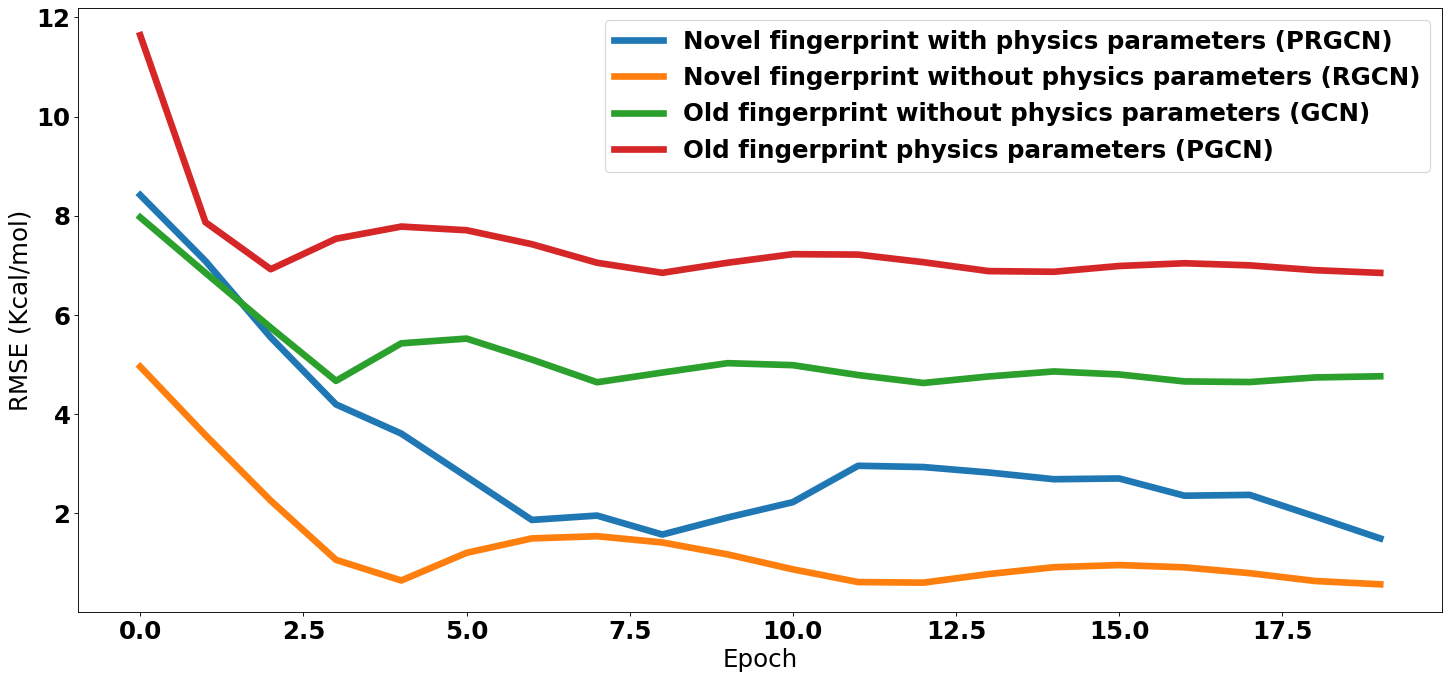

In [11]:
from matplotlib.pyplot import figure
import matplotlib
figure(figsize=(22, 10), dpi=80)
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.plot(np.array(res_pgcn_pg['loss'])[:20], label='Novel fingerprint with physics parameters (PRGCN)', linewidth=6)
plt.plot(res_pgcn_dd['loss'], label='Novel fingerprint without physics parameters (RGCN)', linewidth=6)
plt.plot(res_pgnn_dd['loss'], label='Old fingerprint without physics parameters (GCN)', linewidth=6)
plt.plot(res_pgnn_pg['loss'], label='Old fingerprint physics parameters (PGCN)', linewidth=6)
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('RMSE (Kcal/mol)', fontsize=22)
plt.legend()
plt.show()

# Analysis of weight

In [40]:
weights = pickle.load(open('weights_pgcn', 'rb'))

In [17]:
weights.shape

(35,)

In [41]:
coeffs = weights

In [22]:
features = [x.replace('IV', 'Implicit Valence')
 .replace('H', 'Hydrogen')for x in ['Atom Type C', 'Atom Type N', 'Atom Type O', 'Atom Type S', 'Atom Type F', 'Atom Type Unknown', 
                                    'Atom Degree 0', 'Atom Degree 1', 'Atom Degree 2', 'Atom Degree 3', 'Atom Degree 4',
        'IV 0', 'IV 1', 'IV 2', 'IV 3', 'IV 4', 'IV 5', 'IV 6', 'Formal Charge', '#Radical Electrons',
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'Is Aromatic', '0 H', '1 H', '2 H', '3 H', '4 H', '5 H', '6 H','Atom Mass', 'Atomic No']]

/tmp/ipykernel_33233/4090187316.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


<Figure size 960x640 with 0 Axes>

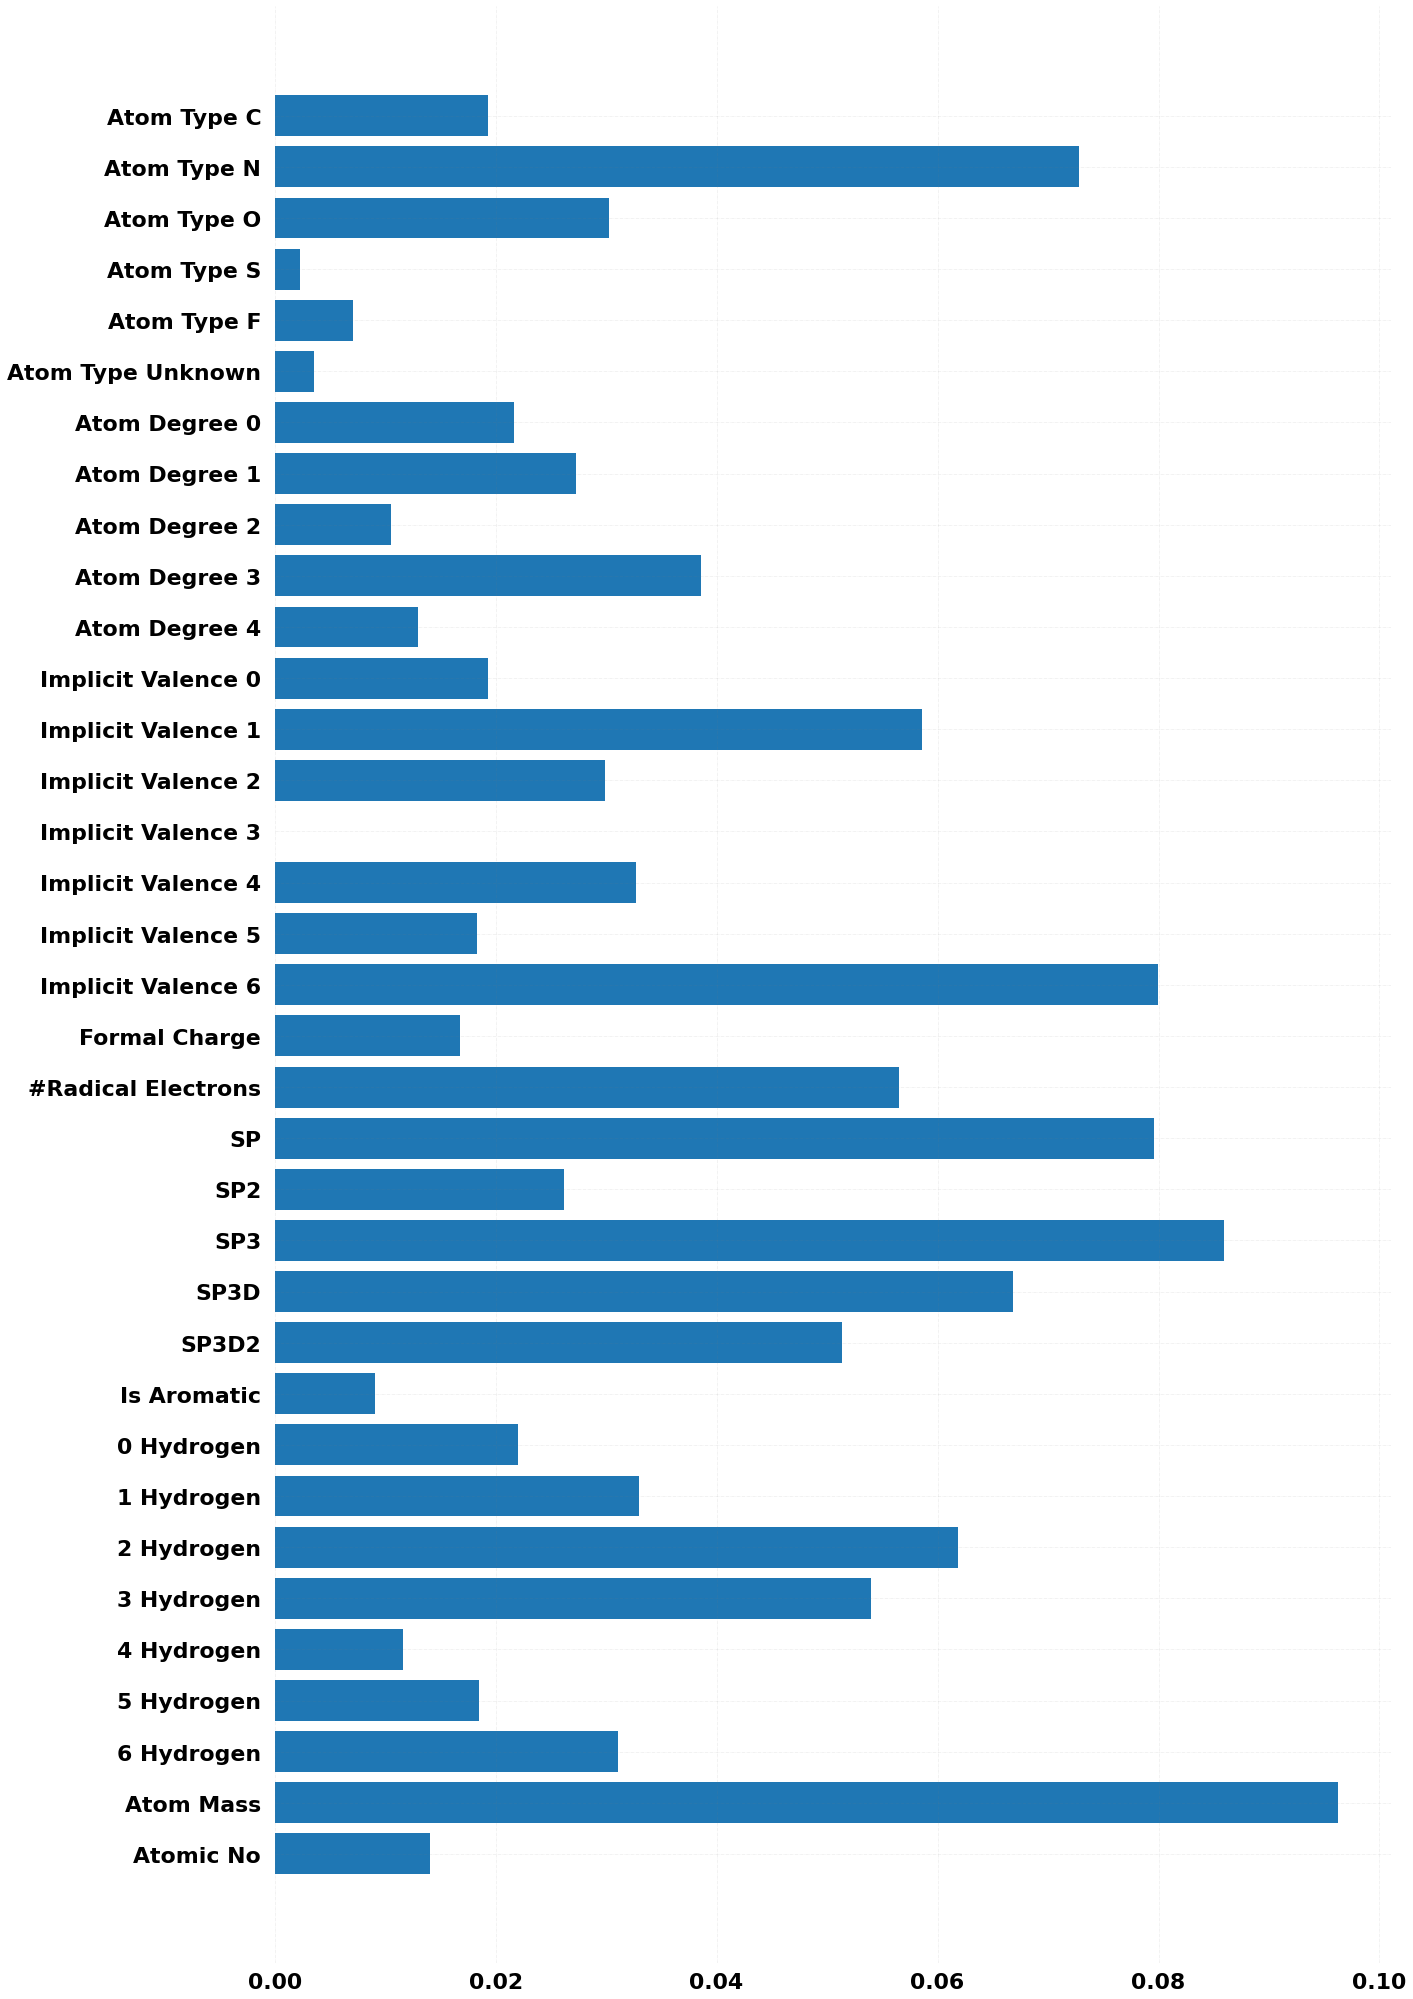

In [23]:
figure(figsize=(12, 8), dpi=80)
fig, ax = plt.subplots(figsize =(20, 36))
 
# Horizontal Bar Plot
ax.barh(features, np.abs(coeffs))
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()

# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')
# fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
#          color ='grey', ha ='right', va ='bottom',
#          alpha = 0.7)
 
# Show Plot
plt.show()

In [84]:
import pickle
with open('pg.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

In [105]:
m.layers[-1].weights[0]

<tf.Variable 'pggcn_model_25/dense6/kernel:0' shape=(16, 1) dtype=float32, numpy=
array([[-0.21952896],
       [-0.27918267],
       [-0.33455047],
       [ 0.08897392],
       [ 0.0091808 ],
       [ 0.34150395],
       [ 0.07576769],
       [ 0.37838626],
       [ 0.45361787],
       [ 0.09978019],
       [-0.56457543],
       [-0.35083595],
       [-0.51481724],
       [-0.47485214],
       [ 0.13435419],
       [ 0.18943757]], dtype=float32)>

In [45]:
tf.matmul(l3[0], m.layers[4].weights[0])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.30114257]], dtype=float32)>

In [109]:
input_shapes = []
for i in range(len(X_test)):
    input_shapes.append(np.array(X_test[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_test)):
    if X_test[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
#         for j in range(2000 - X_atoms[i].shape[0]):
#             new_list.append(np.zeros(53))
#         new_list.append(np.concatenate((info[i], [0]*65)))
        X_test[i] = np.concatenate([X_test[i], new_list], 0)
X_test = np.array(X_test)
y = np.array(y_test)
m.evaluate(X_test, y)

1/1 [==============================] - 3s 3s/step - loss: 25.4363


25.436281204223633

In [111]:
y

array([ 2.74,  2.99, 11.73,  6.16,  6.96,  7.88,  8.42])

In [110]:
m.predict(X_test)

array([[ 5.1323457],
       [ 5.0956197],
       [38.1814   ],
       [38.144802 ],
       [38.108044 ],
       [38.291683 ],
       [38.438297 ]], dtype=float32)

In [5]:
import pickle
res_pure_pgnn = pickle.load(open("../PGGCN/res_pure_pgnn.pkl", "rb"))
res_loss_pgnn = pickle.load(open("../PGGCN/res_loss_pgnn.pkl", "rb"))
res_dd = pickle.load(open("../PGGCN/res_dd.pkl", "rb"))

In [4]:
import matplotlib.pyplot as plt

In [15]:
res_dd

{'loss': [4.957535266876221,
  3.57555890083313,
  2.255244016647339,
  1.061207890510559,
  0.645363450050354,
  1.2023452520370483,
  1.493796467781067,
  1.5381064414978027,
  1.4120174646377563,
  1.171163558959961,
  0.8702523708343506,
  0.613366961479187,
  0.6018031239509583,
  0.7753024697303772,
  0.9126853346824646,
  0.9562525749206543,
  0.9102165699005127,
  0.7926766276359558,
  0.6351305246353149,
  0.567918062210083]}

In [8]:
import pickle
res_pgcn_pg = pickle.load(open('../PGGCN/res.pkl', 'rb'))
res_pgcn_dd = pickle.load(open('../PGGCN/res_dd.pkl', 'rb'))
res_pgnn_pg = pickle.load(open('../PGGCN/res_loss_pgnn.pkl', 'rb'))
res_pgnn_dd = pickle.load(open('../PGGCN/res_pure_pgnn.pkl', 'rb'))

In [30]:
len(res_pgcn_dd['loss'])

20

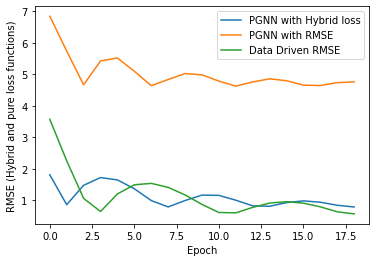

In [20]:
plt.plot(res_loss_pgnn['output_2_loss'][1:], label='PGNN with Hybrid loss')
plt.plot(res_pure_pgnn['loss'][1:], label='PGNN with RMSE')
plt.plot(res_dd['loss'][1:], label='Data Driven RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (Hybrid and pure loss functions)')
plt.legend()
plt.show()

In [38]:
l0 = []
l1 = []
l2 = []
l3 = []
m_v = []
y_p = []
y_r = []
y_p_r = []
y_real_physics_error = []
for i in range(2):
    x = m.layers[0]([X[i]])
    l0.append(x)
    x = m.layers[1](x)
    l1.append(x)
#     x = m.layers[2](x)
    x = m.layers[2](x)
    l2.append(x)
    x = m.layers[3](x)
    l3.append(x)
    x = m.layers[4](x)
    m_v.append(x)
    pure_o = np.matmul(np.concatenate([x[0].numpy()[0].reshape([-1]), info[i].reshape([-1])], 0).reshape([1, -1]), m.layers[len(m.layers) - 1].weights[0].numpy())
#     x = m.layers[6](x)
    y_p.append(pure_o)
    y_p_r.append(np.matmul(info[i], -np.array([-1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])))
    y_real_physics_error.append(np.abs(y[i] - np.matmul(info[i], -np.array([-1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]))))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 616, in new_func
    return func(*args, **kwargs)  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2548, in while_loop_v2
    return while_loop(  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2795, in while_loop
    loop_vars = body(*loop_vars)  File "/home/ali/GBNN/PGGCN/layers_update_mobley.py", line 99, in b
    new_ordered_features.write(j, rule[1](self_features[0][rule[0][0]:rule[0][1]],  File "/home/ali/.local/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **k

In [72]:
X_atoms = []
X_adj = []
for x in X_test:
    X_atoms.append(x[0])
    X_adj.append(x[1])
input_shapes = []
for i in range(len(X_atoms)):
    input_shapes.append(np.array(X_atoms[i]).shape[0])
m.set_input_shapes(input_shapes)
for i in range(len(X_atoms)):
    if X_atoms[i].shape[0] < 2000:
        new_list = X_atoms[i].tolist()
        for j in range(1100 - X_atoms[i].shape[0]):
            new_list.append([0.0]*36)
#         new_list.append(np.concatenate((info[i], [0]*65)))
        X_atoms[i] = np.array(new_list)
m.set_adjacency_list(X_adj)
m.set_physics_info(info_test)
X_atoms = np.array(X_atoms)
y = np.array(y_test)
pred = m.evaluate(X_atoms, y)

1/1 [==============================] - 3s 3s/step - loss: 14.6076 - output_1_loss: 7.3038 - output_2_loss: 7.3038 - output_1_pure_rmse: 7.3038 - output_1_root_mean_squared_error: 12.3038 - output_2_pure_rmse: 7.3038 - output_2_root_mean_squared_error: 12.3038
